# Demo 6: SVM for MNIST Digit Recognition

In this demo, you will learn to:
* Load and display images
* Formulate image classification problems
* Explain the limitations of linear classifiers for image classification
* Build a simple SVM image classifier 
* Save and load results using `pickle`.

For data, we will use the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set used to recognize hand-written digits.  The dataset was originally produced in the 1980s and is now widely-used in machine learning classes as a simple image classification problem.  

## Loading the Data

First, we load the standard packages.

In [75]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Since the MNIST dataset is so widely-used, the `sklearn` module has the dataset built in.  It can be loaded as follows.  We see that the data is stored in an array with 1787 images, each 8 x 8.

In [76]:
from sklearn import datasets, linear_model, preprocessing
digits = datasets.load_digits()
images = digits.images
labels = digits.target
images.shape      #(1797, 8, 8)   每一个图片用8*8像素表示
#labels.shape    #(1797,)   代表数字的具体值
#images[1,:,:]
# plt.imshow(images[1,:,:],  cmap='Greys_r') #因为像素太低所以很模糊 或plt.imshow(images[1],cmap='Greys_r') 

(1797, 8, 8)

The above is fairly low-resolution.  We can get a more high-resolution 28 x 28 image data from the following command.  But, this will take a few minutes to load for some reason.  In this data format, each image is stored as a 784 = 28x28 row vector.

In [77]:
from sklearn.datasets import fetch_mldata
#加载数据
mnist = fetch_mldata("MNIST original")
print("done")

done


In [78]:
mnist.data.shape #(70000, 784)  ，70000组数据，没个图片是28*28=784个数据点

(70000, 784)

We have 70000 image.  Each image is `28 x 28`, which is stored as a 784 pixel vector.  The following code plots a digit.  To do this, it reshapes the 784 dim vector to a `28 x 28` array and then uses the `plt.imshow` command.  

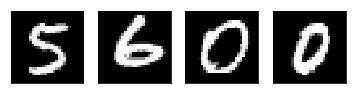

In [79]:
def plt_digit(x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq,  cmap='Greys_r')   #灰度图
    plt.xticks([])   #轴标记
    plt.yticks([])

# Convert data to a matrix
X = mnist.data
y = mnist.target  #真实的数字

# Select random digits
nplt = 4
nsamp = X.shape[0]  #多少张图片
Iperm = np.random.permutation(nsamp)   #打乱（排列），返回副本(这里表示返回一个长度为nsamp的一维数组，shape:(70000,0))
# print(Iperm.shape)    (70000,)

# Plot the images using the subplot command
for i in range(nplt):    #从0开始
#     print(i)
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)   #1*nplt个图片，这里是第i+1个（index从1开始）
    plt_digit(X[ind,:])

## Trying a Logistic Regression Classifier

To classify the digits, we will first use a logistic classifier.  We select a small number of samples for training. Generally, you would use more training samples, but the optimizer is very slow.  

In [80]:
y = mnist.target
ntr = 5000
Xtr = X[Iperm[:ntr],:]   #随机选5000个，因为Iperm是随机（排列）过的
ytr = y[Iperm[:ntr]]

Now we run the optimizer.  I have placed the `verbose=10` （冗余？？）option so that you can see the progress.  It may not appear in the browser but in the command line where you launched jupyter notebook.  This can take several minutes and will likely say that it ran out of iterations.

In [81]:
logreg = linear_model.LogisticRegression(verbose=10, multi_class='multinomial', 
                                         solver='lbfgs', max_iter=500)  #lbfgs：大规模优化算法（一种优化算法？like随机梯度下降）
logreg.fit(Xtr,ytr)

/Users/Lovely-white/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=10, warm_start=False)

Before continuing, since it takes so long to run the optimizer, let's save the results in a file.  You can use `pickle` module for this purpose.

In [82]:
import pickle    #用来序列化 持久化的包

with open( "mnist_logreg.p", "wb" ) as fp:   #with语句类似java中的try  "wb"write binary/bytes?
    pickle.dump( [logreg, X, y, Iperm],  fp)    #将对象存到文件

Then, we can recover the objects via the `pickle.load` command

In [83]:
with open( "mnist_logreg.p", "rb" ) as fp:   #read binary
    logreg, X, y, Iperm = pickle.load(fp)

Now, we can measure the accuracy on the test data.

In [84]:
Xts = X[Iperm[ntr:],:]
yts = y[Iperm[ntr:]]
yhat = logreg.predict(Xts)
acc = np.mean(yhat == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.866554


You should get an accuracy of around 86%.  This may sounds OK, but it is actually very poor.  Had we increased the number of training samples, it would have improved to about 92%, but that is still very bad.  To illustrate, let's plot some of the errors.  

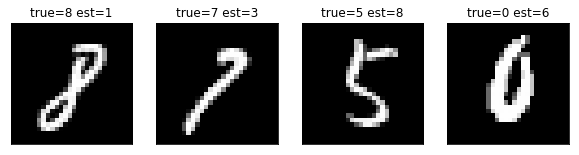

In [85]:
nplt = 4
Ierr = np.where(yts != yhat)[0]
# print(np.where(yts != yhat))  输出是个tuple,[0]是对应的下标

plt.figure(figsize=(10, 4))
for i in range(nplt):        
    plt.subplot(1,nplt,i+1)        
    ind = Ierr[i]    
    plt_digit(Xts[ind,:])        
    title = 'true={0:d} est={1:d}'.format(yts[ind].astype(int), yhat[ind].astype(int))
    plt.title(title)

Obviously, some of these digits are very easy to classify for a human.  We can get more fine-grained analysis of the digit errors by computing the confusion matrix.

[[ 0.936  0.     0.014  0.004  0.003  0.016  0.016  0.001  0.01   0.001]
 [ 0.     0.968  0.008  0.003  0.001  0.006  0.001  0.005  0.01   0.004]
 [ 0.007  0.011  0.85   0.027  0.019  0.009  0.014  0.013  0.04   0.01 ]
 [ 0.01   0.005  0.035  0.837  0.002  0.057  0.005  0.013  0.03   0.014]
 [ 0.003  0.008  0.011  0.001  0.852  0.008  0.021  0.009  0.01   0.074]
 [ 0.019  0.006  0.018  0.049  0.012  0.77   0.025  0.007  0.058  0.015]
 [ 0.006  0.002  0.031  0.001  0.015  0.019  0.919  0.001  0.006  0.   ]
 [ 0.004  0.004  0.02   0.009  0.011  0.002  0.001  0.881  0.008  0.068]
 [ 0.009  0.018  0.028  0.034  0.007  0.071  0.014  0.003  0.796  0.02 ]
 [ 0.006  0.007  0.005  0.014  0.045  0.011  0.001  0.056  0.022  0.833]]


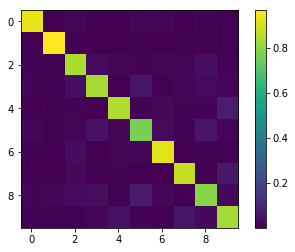

In [86]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(yts,yhat) #混淆矩阵：真实vs预测

# Normalize the confusion matrix
Csum = np.sum(C,1)  #axis=1,左右压扁,
# print(Csum.shape) #(10,)
C = C / Csum[None,:]  #行和列和都不为1，这在干啥？？？

# Print the confusion matrix
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')   #插值运算。interpolation='nearest'则近似成块？
plt.colorbar()   #右边那个条条

## Visualizing the Weights

To see the problem with the logistic classifier, it is useful to plot the weights for each digit.  

(10, 784)


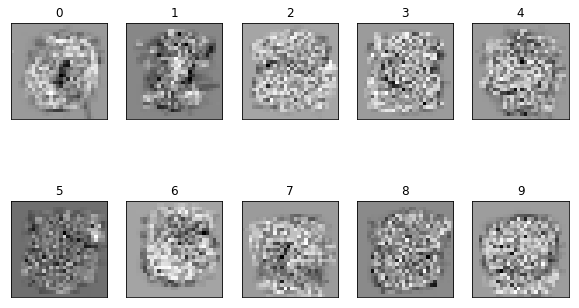

In [87]:
W = logreg.coef_
# print(W.shape)  (10, 784)
nlabel = W.shape[0]
plt.figure(figsize=(10, 6))
for i in range(nlabel):
    plt.subplot(2,5,i+1)
    plt_digit(W[i,:])    #打印系数w（也是一个矩阵，表示每一个像素点的wight）
    plt.title('{0:d}'.format(i))

What you see is that each weight is a very blurry version of the digit.  The blurriness is due to the fact that weight must correlate with all shifts, rotations and other variations of the digits.  As a result, the weights begin to correlate with other incorrect digits leading to poor performance.

## Run an SVM classifier

We now try an SVM classifier.  The parameters are given by 

https://martin-thoma.com/svm-with-sklearn/

This website has a nice summary of the main equations for SVM as well.  That site trained on 40000 samples and tested on 20000.  But, to make this run faster, we will train on 10000 and test on 10000.  If you increase to 40000 training samples, you can get past 99% accuracy.

First, we import the SVM package and construct the SVC with the parameters.

In [88]:
from sklearn import svm

# Create a classifier: a support vector classifier
svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073,verbose=10)   #径向基函数 (Radial Basis Function 简称 RBF

Next, we get the training and test data.  The features are re-scaled to be between -1 and 1.

In [89]:
Xs = X/255.0*2 - 1  #原本值得范围是0-256 （16^2）
ntr = 10000
nts = 10000
Xtr = Xs[Iperm[:ntr],:]
ytr = y[Iperm[:ntr]]
Xts = Xs[Iperm[ntr:ntr+nts],:]
yts = y[Iperm[ntr:ntr+nts]]

We fit the training data.  Again, this will take several minutes.

In [90]:
svc.fit(Xtr,ytr)

[LibSVM]

SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0073, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=10)

Save the results in case you want them without re-running the above the code.

In [91]:
import pickle

with open( "mnist_svc.p", "wb" ) as fp:
    pickle.dump( [svc, Xs, y, Iperm, ntr, nts], fp)

We can reload the data

In [92]:
import pickle
with open( "mnist_svc.p", "rb" ) as fp:
    svc, Xs, y, Iperm, ntr, nts = pickle.load(fp)
Xtr = Xs[Iperm[:ntr],:]
ytr = y[Iperm[:ntr]]
Xts = Xs[Iperm[ntr:ntr+nts],:]
yts = y[Iperm[ntr:ntr+nts]]

Measure the accuracy on the test data.  The prediction can take several minutes too -- SVMs are *very* slow!

In [93]:
yhat_ts = svc.predict(Xts)
acc = np.mean(yhat_ts == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.968200


You should get an accuracy of around 96%.  Again, had you trained on all 50,000 samples, it would have been much better -- close to 98.5%.  But, even this result is much better than logistic regression.

Since even the prediction (sometimes called inference) is slow with SVMs, we will save the results in `pickle` file.

In [94]:
with open("mnist_svc_test.p", "wb") as fp:
    pickle.dump([yts,yhat_ts,Xts], fp)

Instead of running the prediction again, you can recapture the data with the following comamnd

In [95]:
with open("mnist_svc_test.p", "rb") as fp:
    yts,yhat1,Xts = pickle.load(fp)

Plot some errors

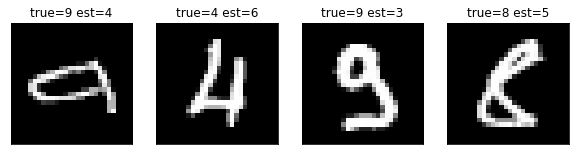

In [96]:
Ierr = np.where((yhat_ts != yts))[0]
nplt = 4
plt.figure(figsize=(10, 4))
for i in range(nplt):        
    plt.subplot(1,nplt,i+1)        
    ind = Ierr[i]    
    plt_digit(Xts[ind,:])        
    title = 'true={0:d} est={1:d}'.format(yts[ind].astype(int), yhat1[ind].astype(int))
    plt.title(title)

We see that again a human would not have made these errors, but the digits in error are much less clear.

## Looking at the Support Vectors

Let's take a look at the support vectors.  We see there about 5000 support vectors.  So, about half the training samples were used as SVs.  This is partly why the prediction was so slow.

In [97]:
S = svc.support_vectors_
S.shape  #4939个SV， 28*28=784个数据点

(4939, 784)

We can plot some of the vectors.

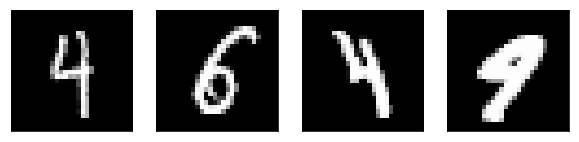

In [98]:
nplt = 4
nsv = S.shape[0]
Iperms = np.random.permutation(nsv)
plt.figure(figsize=(10, 4))
for i in range(nplt):        
    plt.subplot(1,nplt,i+1)        
    ind = Iperms[i]
    plt_digit(S[ind,:])        